In [125]:
import numpy as np
from numpy import *
from numpy import random
from numpy import linalg as LA
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import networkx as nx
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx

from matplotlib.colors import ListedColormap


# After np version 19 ragged np arrays lead to a VisibleDeprecationWarning, which can be turned off: 


In [133]:
def create_custom_colormap():
    """
    Create a custom colormap where zero is black and positive integers follow the tab20 colormap.
    
    Returns:
    custom_cmap (ListedColormap): The custom colormap for the image.
    """
    # Create a base colormap from tab20
    base_cmap = plt.cm.get_cmap('tab20', 20)

    # Create a list of colors where the first color is black (for zero elements)
    # and the rest are from the tab20 colormap
    colors = [(0, 0, 0, 1)] + [base_cmap(i) for i in range(base_cmap.N)]
    
    # Create a custom colormap
    custom_cmap = ListedColormap(colors)

    return custom_cmap


def create_custom_colormap():
    """
    Create a custom colormap where zero is black and positive integers follow the tab20 colormap.

    Returns:
    custom_cmap (ListedColormap): The custom colormap for the image.
    """
    # Create a base colormap from tab20
    base_cmap = plt.colormaps['tab20']

    # Create a list of colors where the first color is black (for zero elements)
    # and the rest are from the tab20 colormap
    colors = [(0, 0, 0, 1)] + [base_cmap(i) for i in range(base_cmap.N)]

    # Create a custom colormap
    custom_cmap = ListedColormap(colors)

    return custom_cmap

In [303]:
# Load all data into one list, the list is not partitioned: the first i entries correspond to the first fc value, 
# ..then after every period of length i a new fc value is assigned, resulting in total of j periods of length i


def getNetwork(i_network, plot=True):
    nsim=100
    baseAddress="/home/alifeleparanj/Projects/MathMaster/Data/UcarPaper/"
    
    coordinates_all = []
    for j in arange(0.4,1.6,0.1):
        for i in range(nsim):
            coordinates_all.append(np.load(baseAddress+'Simulations/axial_data/fcbias_parallel_pb003_fa0_fc'+str(round(j,1)).replace('.','')+'_coord_v'+str(int(i))+'.npy'))
            
    angles_all = []
    for j in arange(0.4,1.6,0.1):
        for i in range(nsim):
            angles_all.append(np.load(baseAddress+'Simulations/axial_data/fcbias_parallel_pb003_fa0_fc'+str(round(j,1)).replace('.','')+'_angles_v'+str(int(i))+'.npy'))

    network = coordinates_all[i_network]
    return turnCoordinateIntoMatrix(network,plot=True)

def loadExperimentalData(i_network, plot=True):
    baseAddress="/home/alifeleparanj/Projects/MathMaster/Data/UcarPaper/"
    v = i_network%8
    names=['f1','f2','f3','f4','A5','A7','A8f1','A8f2']
    sample_name = names[v]
    
    # Load coordinate and local angle values from saved data
    coordinates=np.load(baseAddress+'Experiment/expdata_'+sample_name+'_coordinates_rescaled.npy')
    angle_list=np.load(baseAddress+'Experiment/expdata_'+sample_name+'_localangle_rescaled.npy')
    
    # The estimated coordinates for the origin of the network
    origin = np.load(baseAddress+'Experiment/expdata_'+sample_name+'_origin_coordinates_left.npy')
    # location of the origin coordinate within the array "coordinates":
    orig_pos = np.argmin(LA.norm(np.add(origin[:2],-coordinates[:,:2]),axis=1))

    return turnCoordinateIntoMatrix(coordinates,plot=True)



def turnCoordinateIntoMatrix(network,plot=True):
    lenList = []
    max_x = int(np.ceil(np.max(network[:, 0])))
    max_y = int(np.ceil(np.max(network[:, 1])))
    min_x = int(np.ceil(np.min(network[:, 0])))
    min_y = int(np.ceil(np.min(network[:, 1])))
    margin = 20
    vascular_matrix = np.zeros((max_y-min_y+margin, max_x -min_x+margin), dtype=np.int32)
    for i in range(int(network[-1,-1])):
        segment = network[network[:,-1]==i]
        if plot == True:
            plt.plot(segment[:,0],(max_y-min_y)-segment[:,1])
            plt.axis("square")
        lenList.append(segment.shape[0])
        for x, y, parent,selfID in segment[:, :4]:
            vascular_matrix[int(y-min_y+margin/2), int(x-min_x+margin/2)] = (1)+selfID
    
    return vascular_matrix




def enhance_for_loops(A,kernelSize):
    # Assuming binary_matrix is your binary image (numpy array)
    # For demonstration, let's create a random binary matrix
    binary_matrix = A.astype(np.uint8) * 255  # Convert to 8-bit format with 0 and 255
    

    # Define a kernel for dilation (structuring element)
    kernel_size = kernelSize  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply dilation
    dilated_image = cv2.dilate(binary_matrix, kernel, iterations=1)
    
    kernel_size = kernel_size-1  # You can adjust this size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(dilated_image, kernel, iterations=1)
    
    # kernel_size = 1 # You can adjust this size
    # kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # final_image = cv2.dilate(eroded_image, kernel, iterations=1)
    final_image = eroded_image.copy()
    return final_image    
    
    
    # # Display the original and dilated images
    # plt.figure(figsize=(10, 10))
    
    # plt.subplot(1, 3, 1)
    # plt.title('Original Binary Image')
    # plt.imshow(binary_matrix, cmap='gray')
    
    # plt.subplot(1, 3, 2)
    # plt.title('Dilated Image')
    # plt.imshow(dilated_image, cmap='gray')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Eroded Image')
    # plt.imshow(eroded_image, cmap='gray')
    
    # plt.show()


In [304]:


def map_to_square(arr,dest):
    # Find the minimum and maximum values for each column (x and y coordinates)
    min_vals = arr.min(axis=0)
    max_vals = arr.max(axis=0)
    
    # Normalize the coordinates to [0, 1]
    norm_arr = (arr - min_vals) / (max_vals - min_vals)
    
    # Scale and shift to [-1, 1]
    shift = dest -np.array([1,0])
    scaled_arr = norm_arr * 2 +shift
    
    return scaled_arr


# Step 1: Skeletonize the Image
def skeletonize_image(binary_image):
    return skeletonize(binary_image // 255).astype(np.uint8)

# Step 2: Detect Nodes and Edges
def detect_nodes_edges(skeleton):
    # Identify all nodes
    # Use a connectivity-8 kernel to find nodes
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)
    convolved = cv2.filter2D(skeleton, -1, kernel)
    
    nodes = np.where((convolved > 10) & (convolved < 18))
    
    return list(zip(nodes[1], nodes[0]))

# Step 3: Create a Graph
def create_graph(skeleton, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    
    for node in nodes:
        x, y = node
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                if skeleton[y + dy, x + dx] == 1:
                    neighbor = (x + dx, y + dy)
                    if neighbor in nodes:
                        G.add_edge(node, neighbor)
    
    return G

# Step 4: Find Cycles
def find_cycles(graph):
    cycles = list(nx.cycle_basis(graph))
    return cycles




# Optional: Visualize the results
def visualize_cycles(image, cycles):
    plt.imshow(image, cmap='gray')
    for cycle in cycles:
        cycle = np.array(cycle)
        plt.plot(cycle[:, 0], cycle[:, 1], 'r-')
    plt.show()



def detectLoops(final_image, plot=True):
    
    # final_image = final_image.astype(np.uint8) * 255
    binary_image = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)[1]
    
    skeleton = skeletonize_image(binary_image)
    nodes = detect_nodes_edges(skeleton)
    graph = create_graph(skeleton, nodes)
    cycles_unfiltered = find_cycles(graph)
    
    cycles = [sublist for sublist in cycles_unfiltered if len(sublist) >= 5]
    for cycle in cycles:
        cycle.append(cycle[0])
    
    print(f"Detected {len(cycles)} cycles in the image.")

    if plot == True:
        visualize_cycles(skeleton, cycles)
    
    return skeleton, cycles, graph




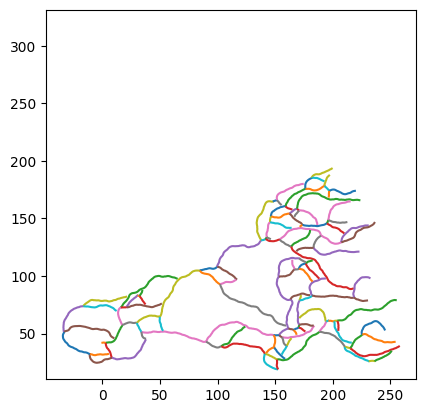

In [305]:
network = getNetwork(5)
# network = loadExperimentalData(1)
network = enhance_for_loops(network,2) ## Change the value of kernel size to filter different loop sizes

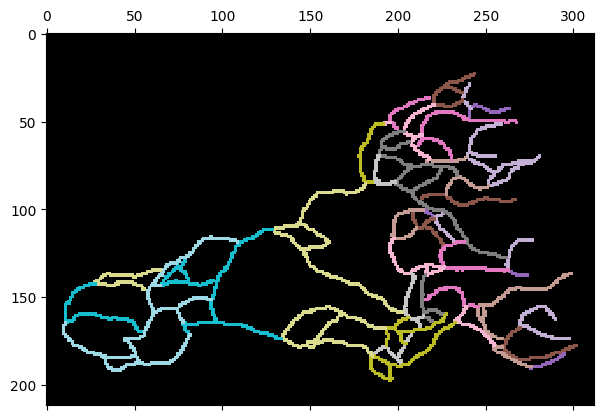

In [306]:
plt.matshow(network,cmap=create_custom_colormap())

Detected 51 cycles in the image.


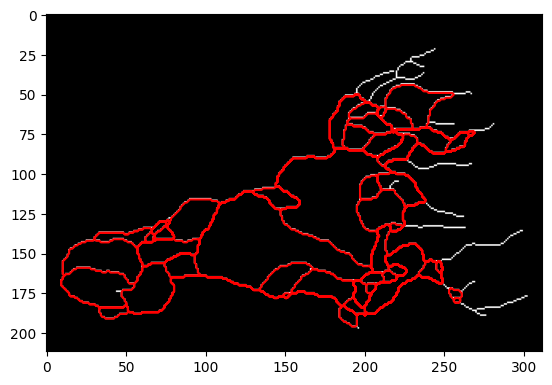

In [307]:
skeleton, cycles, graph = detectLoops(network)